#**Topic Modeling** 
is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. 

The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

# **LDA Model (NGRAMS + NOUNS)**

In this notebook, we present the approach of using **NGRAMS (1-gram, 2-grams and 3-grams) + Nouns only** apprach to build a LDA topic model using the Gensim Library.

## **Import Libraries, Packages and Data**

In [ ]:
!pip install pyLDAvis
!pip install -U gensim==3.8.0

import pandas as pd
#import numpy as np
from pprint import pprint

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('punkt')

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

     |████████████████████████████████| 1.7 MB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=409ee7e76f82e57041218ea7201a842a80989d0b894ad87edbb23cbb64744c5e
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
     |████████████████████████████████| 24.2 MB 8.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Mount to GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Data**

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Hotel_Datasets/515k_Hotel_Reviews_NOUNS_TOKENS.csv'
df = pd.read_csv(path)
df.head(5)

,cleaned_Reviews
0,"['hotel', 'mess', 'hotel', 'star']"
1,"['change', 'sheet', 'duvet', 'everyday', 'bed'..."
2,"['price', 'brekfast']"
3,"['picture', 'room', 'room', 'quit', 'dirty', '..."
4,"['aircondition', 'sleep', 'night']"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545181 entries, 0 to 545180
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   cleaned_Reviews  545181 non-null  object
dtypes: object(1)
memory usage: 4.2+ MB


**10000 random samples for Topic Modelling**

In [ ]:
df_sample = df.sample(10000, random_state=120)

In [ ]:
df_sample = df_sample.reset_index(drop=True)

In [ ]:
df_sample

,cleaned_Reviews
0,"['service', 'gave_u_free', 'bottle', 'room', '..."
1,"['room', 'immaculate', 'bar', 'view', 'oxford_..."
2,"['hotel', 'room', 'bed', 'bathroom', 'term', '..."
3,"['city', 'grea', 'thotel']"
4,"['front_desk', 'help', 'delight', 'stay', 'mor..."
...,...
9995,"['room', 'bathroom', 'room', 'word', 'describe..."
9996,"['staff', 'roof_terrace']"
9997,['staff']
9998,"['hotel', 'night']"


## **Reviews Pre-processing**

**Remove Punctuations**

In [ ]:
df_sample["Reviews"] = df_sample['cleaned_Reviews'].str.replace('[^\w\s]','')

<input>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-8-1e9b69d4e2be>:1: DeprecationWarning: invalid escape sequence \w
  df_sample["Reviews"] = df_sample['cleaned_Reviews'].str.replace('[^\w\s]','')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


**Create Dataframe of Reviews**

In [ ]:
# Extract only reviews text
reviews = df_sample.Reviews

In [ ]:
reviews.head()

0    service gave_u_free bottle room victoria spong...
1    room immaculate bar view oxford_street recepti...
2    hotel room bed bathroom term hotel experience ...
3                                     city grea thotel
4    front_desk help delight stay morning brekfast ...
Name: Reviews, dtype: object

**Convert reviews dataframe to list**

In [ ]:
reviews = reviews.tolist()

**Tokenize the sentence into words**

In [ ]:
import string 

#Tokenize the sentence into words
reviews_tokens = [word_tokenize(t) for t in reviews]

**Samples of reviews tokens**

In [ ]:
reviews_tokens[:5]

[['service', 'gave_u_free', 'bottle', 'room', 'victoria', 'sponge', 'thank'],
 ['room',
  'immaculate',
  'bar',
  'view',
  'oxford_street',
  'reception',
  'delightful',
  'shop',
  'rest',
  'shop',
  'palladium',
  'dinner',
  'grill',
  'bus',
  'street'],
 ['hotel',
  'room',
  'bed',
  'bathroom',
  'term',
  'hotel',
  'experience',
  'bathrobe_slipper',
  'room',
  'commend',
  'spa',
  'space'],
 ['city', 'grea', 'thotel'],
 ['front_desk',
  'help',
  'delight',
  'stay',
  'morning',
  'brekfast',
  'delight',
  'morning']]

**Create a dictionary (mapping between words and their integer ids)**

In [ ]:
dictionary = corpora.Dictionary(reviews_tokens)  

**Converts the word to its integer word id and returns the result as a sparse vector (using Doc2bow Doc term matrix)**

In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews_tokens]

**Samples of doc_term_matrix (corpus)**

In [ ]:
doc_term_matrix[:5]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(2, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1)],
 [(2, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(29, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1)]]

**Human readable format of corpus**

In [ ]:
# Human readable format of corpus
[[(dictionary[id], freq) for id, freq in cp] for cp in doc_term_matrix[:5]]

[[('bottle', 1),
  ('gave_u_free', 1),
  ('room', 1),
  ('service', 1),
  ('sponge', 1),
  ('thank', 1),
  ('victoria', 1)],
 [('room', 1),
  ('bar', 1),
  ('bus', 1),
  ('delightful', 1),
  ('dinner', 1),
  ('grill', 1),
  ('immaculate', 1),
  ('oxford_street', 1),
  ('palladium', 1),
  ('reception', 1),
  ('rest', 1),
  ('shop', 2),
  ('street', 1),
  ('view', 1)],
 [('room', 2),
  ('bathrobe_slipper', 1),
  ('bathroom', 1),
  ('bed', 1),
  ('commend', 1),
  ('experience', 1),
  ('hotel', 2),
  ('spa', 1),
  ('space', 1),
  ('term', 1)],
 [('city', 1), ('grea', 1), ('thotel', 1)],
 [('brekfast', 1),
  ('delight', 2),
  ('front_desk', 1),
  ('help', 1),
  ('morning', 2),
  ('stay', 1)]]

## **Model Building**

**Compute coherence score for models with different number of topics (Try from 2 topics - 40 topics)**

In [ ]:
# Testing of which number of topics is the most optimal
# Compute coherence score for each number of topics between 2 - 40 topics

#
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus= corpus,
                                                              num_topics=num_topics,
                                                              id2word=dictionary,
                                                              random_state=100,
                                                              update_every=1,
                                                              chunksize=1000,
                                                              passes=10, 
                                                              alpha='auto',
                                                              per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Compute coherence score between 2 - 40 topics with a step of 2 for each iteration

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_tokens, start=2, limit=40, step=2)

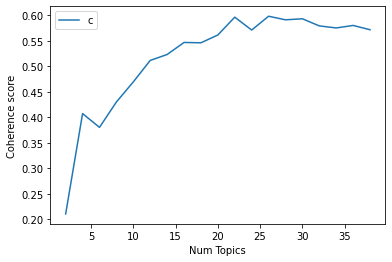

In [ ]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2105
Num Topics = 4  has Coherence Value of 0.4074
Num Topics = 6  has Coherence Value of 0.3803
Num Topics = 8  has Coherence Value of 0.4301
Num Topics = 10  has Coherence Value of 0.4696
Num Topics = 12  has Coherence Value of 0.5117
Num Topics = 14  has Coherence Value of 0.5234
Num Topics = 16  has Coherence Value of 0.547
Num Topics = 18  has Coherence Value of 0.5463
Num Topics = 20  has Coherence Value of 0.5616
Num Topics = 22  has Coherence Value of 0.5967
Num Topics = 24  has Coherence Value of 0.5714
Num Topics = 26  has Coherence Value of 0.5984
Num Topics = 28  has Coherence Value of 0.5915
Num Topics = 30  has Coherence Value of 0.5935
Num Topics = 32  has Coherence Value of 0.5795
Num Topics = 34  has Coherence Value of 0.5755
Num Topics = 36  has Coherence Value of 0.5804
Num Topics = 38  has Coherence Value of 0.572


Finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

Observing the line graph, we can see that coherence score starts to flatten out from roughly around 22 topics onwards. 

Hence, we will be choosing 22 number of topics to build our topic model and investigate further.

## **Topic Model with Num Topic = 22**

In [ ]:
import time

start_time = time.time()

# Single core LDA
NUM_TOPICS = 22

lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=NUM_TOPICS, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto')
                                          #  per_word_topics=True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 14.966918468475342 seconds ---


**Save & Load the model**

In [ ]:
# Save & Load the model
lda_model.save('/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Topic Modelling/Topic Models/LDA_model_NOUNS')
lda_model = gensim.models.ldamodel.LdaModel.load('/content/drive/MyDrive/Colab Notebooks/Hotel_Analysis/Topic Modelling/Topic Models/LDA_model_NOUNS')

**Show Topic Keywords**

In [ ]:
# Show the 5 most dominant words in each topic

lda_model.print_topics(num_words = 10)

[(8,
  '0.149*"clean" + 0.105*"noise" + 0.057*"pay" + 0.034*"twin" + 0.031*"milan" + 0.030*"fab" + 0.028*"request" + 0.025*"card" + 0.024*"luxury" + 0.024*"everyone"'),
 (20,
  '0.120*"pool" + 0.116*"need" + 0.103*"bedroom" + 0.094*"morning" + 0.070*"hour" + 0.060*"cost" + 0.051*"lack" + 0.046*"elevator" + 0.038*"entrance" + 0.019*"detail"'),
 (13,
  '0.284*"time" + 0.093*"kind" + 0.070*"customer" + 0.062*"issue" + 0.055*"noisy" + 0.053*"cold" + 0.044*"shop" + 0.031*"proximity" + 0.025*"swimming_pool" + 0.018*"tourist"'),
 (11,
  '0.218*"place" + 0.100*"decor" + 0.096*"convenient" + 0.068*"comfort" + 0.057*"money" + 0.051*"feel" + 0.051*"carpet" + 0.041*"line" + 0.021*"return" + 0.019*"hair"'),
 (21,
  '0.059*"concierge" + 0.052*"side" + 0.051*"toilet" + 0.050*"towel" + 0.049*"dirty" + 0.046*"value_money" + 0.045*"change" + 0.042*"wall" + 0.024*"chocolate" + 0.022*"minibar"'),
 (6,
  '0.251*"facility" + 0.101*"quality" + 0.063*"access" + 0.047*"rate" + 0.042*"eat" + 0.041*"visit" + 0.0

**Compute Perplexity & Coherence Score**

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.438863852729883

Coherence Score:  0.5966539130213574


## **Visualize the topics using pyLDAvis**

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.045190  0.406788       1        1  14.567283
17    -0.412971 -0.057422       2        1  11.828531
19    -0.008833  0.135034       3        1   7.796875
18     0.002163  0.127242       4        1   7.023596
2     -0.370744 -0.078468       5        1   6.650886
4      0.019552  0.046078       6        1   5.230505
16     0.034570  0.037204       7        1   4.604542
10     0.028740  0.002544       8        1   3.932511
7      0.034442 -0.009891       9        1   3.543684
9      0.045717 -0.027397      10        1   3.349401
3      0.035238 -0.009082      11        1   3.282646
15     0.053119 -0.043604      12        1   2.987170
12     0.053680 -0.026844      13        1   2.949873
1      0.044983 -0.036234      14        1   2.879218
14     0.055864 -0.048329      15        1   2.784735
0      0.055334 -0.047940      16        1   2.651252
6      0.059027 -0.054888      17        1   2.543503
21     0.062326 -0.066255      18        1   2.461084
13     0.062133 -0.060303      19        1   2.304419
11     0.061071 -0.058480      20        1   2.263894
20     0.063617 -0.062791      21        1   2.249066
8      0.066162 -0.066963      22        1   2.115327, topic_info=          Term         Freq        Total Category  logprob  loglift
2         room  4642.000000  4642.000000  Default  30.0000  30.0000
54       staff  2988.000000  2988.000000  Default  29.0000  29.0000
25       hotel  2020.000000  2020.000000  Default  28.0000  28.0000
50    location  2505.000000  2505.000000  Default  27.0000  27.0000
48   breakfast  1750.000000  1750.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
335    arrange     7.528143     8.522003  Topic22  -4.7051   3.7320
83   attentive     6.599914     7.593774  Topic22  -4.8367   3.7157
705       come     5.213248     6.207107  Topic22  -5.0726   3.6815
917     course     4.024652     5.018512  Topic22  -5.3313   3.6353
721      fresh     3.710499     4.704358  Topic22  -5.4126   3.6186

[724 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
374      17  0.985481         access
660       5  0.908096  accommodation
309      13  0.853636   accomodation
860       3  0.943905    across_road
202      12  0.687791  across_street
...     ...       ...            ...
577       4  0.678337   wooden_floor
150      10  0.993287           work
610       2  0.920725          world
156       2  0.490410     wow_factor
966       1  0.974378           year

[651 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 18, 20, 19, 3, 5, 17, 11, 8, 10, 4, 16, 13, 2, 15, 1, 7, 22, 14, 12, 21, 9])

**Observation of Topics:**

Although we managed to obtain a relatively high coherence score of 0.597, we observe from the pyLDAvis visualisation that a lot of our topics are clustered closely together.

This would not be good, as ideally we will need more diverse topics distribution to be able to identify clearly what each of the topics are talking about.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

We would attempt trying out the topic modelling using the exact same words (NGRAMS + NOUNS) using the LDA Mallet architecture. LDA Mallet is said to offer better quality of topics.

Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/